# Data Retrieval & Preprocessing
This notebook serves as a guide to retrieve and preprocess the data we use in this project. As a reminder, we need aerial images from Switzerland, with a non-negligible proportion featuring solar panels. Parts of this notebook were written by data scientists from the [Swiss Data Science Center](https://www.datascience.ch), who we thank for their work.

In [ ]:
import os
import re
import numpy as np
import pandas as pd
import geopandas as gpd
import requests
import sys

import matplotlib.pyplot as plt
import matplotlib.cm as cm
import matplotlib.colors as colors
from mpl_toolkits.axes_grid1 import make_axes_locatable

from tqdm import tqdm
from PIL import Image

src_path = os.path.abspath("../src")
if src_path not in sys.path:
    sys.path.append(src_path)
    
from plotting import plot_mask_on_image
from preprocessing import keep_roofs, load_json_labels, generate_label_masks

## Download tiles w/ rooftops

The [swisstopo](https://www.swisstopo.admin.ch/fr/photographies-aeriennes-analogiques#Informations-complémentaires) agency provides aerial images of Switzerland with a resolution of $10\text{cm}$. We will use these as our base dataset. We need a large number of images containing solar panels, despite they are relatively rare with respect to the total number of images. To do so, we will use the [data.geo.admin.ch](https://data.geo.admin.ch/) API to filter out images that do not contain any rooftops, since they are very unlikely to contain PV installations.

The first step is downloading the rooftop dataset, which contains polygons corresponding to every rooftop in Switzerland. It is available [here](https://data.geo.admin.ch/ch.bfe.solarenergie-eignung-daecher/solarenergie-eignung-daecher/solarenergie-eignung-daecher_2056.gpkg.zip). You should put it in the `data/roofs/coordinates` folder. In the following code, we determine the number of rooftops / km², so as to retrieve the best tiles.

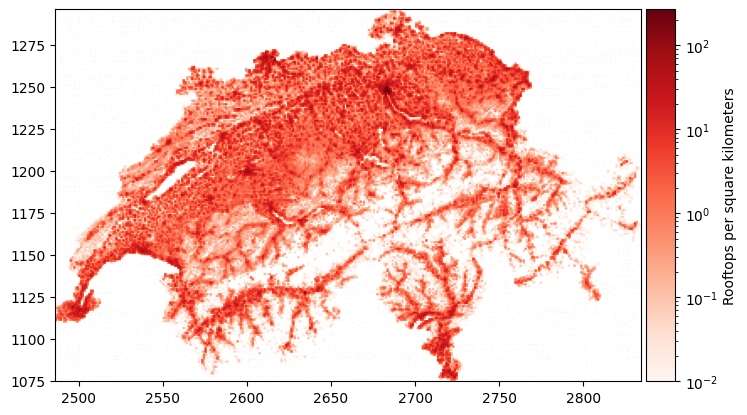

In [11]:
# Load the whole rooftop dataset
path = "../data/roofs/coordinates/SOLKAT_DACH.gpkg"

# Note: we only read the geometry data, no other column is loaded
gdf = gpd.read_file(
    path,
    layer="SOLKAT_CH_DACH",
    columns=[],
    engine="pyogrio",
    use_arrow=True,
)

# Simplify polygons as points
centroids = gdf.centroid

# Aggregate & count how many rooftops we expect on each tile
df = pd.DataFrame(index=centroids.index)
df["i"] = (centroids.x / 1000).astype(int)
df["j"] = (centroids.y / 1000).astype(int)
counts = df.value_counts()

# Get covered area
i_min = df["i"].min()
i_max = df["i"].max() + 1
j_min = df["j"].min()
j_max = df["j"].max() + 1

# Compute histogram
histogram = np.zeros((j_max - j_min, i_max - i_min), dtype=int)
for (i, j), count in counts.items():
    histogram[j - j_min, i - i_min] = count

# Show density per square kilometer
fig, ax = plt.subplots(figsize=(8, 8))
im = ax.imshow(
    histogram / 100,
    cmap="Reds",
    norm=colors.LogNorm(),
    origin="lower",
    extent=(i_min, i_max, j_min, j_max),
)
divider = make_axes_locatable(ax)
cax = divider.append_axes("right", size="5%", pad=0.05)
cbar = fig.colorbar(im, cax=cax) 
cbar.set_label("Rooftops per square kilometers")

Now, we can keep only tiles having a sufficient number of rooftops, which we set to $400$.

In [12]:
# Consider only cases where we have enough rooftops
threshold = 400
candidates = counts[counts >= threshold].index
print(f"{(len(candidates) / len(counts)) * 100:.2f}% of the tiles have at least {threshold} rooftops.")

21.23% of the tiles have at least 400 rooftops.


We use a predefined list of all available tile URLs, which we filter out to match our new criteria. It is located in `data/urls` folder.

During our experiments, we started by generating $258$ images, without seeding the generator. These additional images are present and labelled in the dataset on [Kaggle](https://www.kaggle.com/datasets/jeanprbt/swiss-solar-panels-segmentation/data?select=images), but cannot be generated again, since they were completely random. We then used two additional seeds, namely $1$, $42$, to download the tiles of $500$ more images and then label them : that's why they're predefined here. They will be downloaded in the `data/tiles` folder in the `tif` format, they cover exactly $1\text{km} \times 1\text{km}$ and have a resolution of $10\text{cm}$, which corresponds to $10000 \times 10000$ pixels.

In [13]:
url_df = pd.read_csv("../data/urls/urls.csv", header=None, names=["url"])

# Extract coordinates
ij_df = url_df["url"].str.extract(r"swissimage-dop10_\d+_(?P<i>\d+)-(?P<j>\d+)").astype(int)
url_df = pd.concat([url_df, ij_df], axis=1).set_index(["i", "j"])

# Keep only the available coordinates
candidates = candidates.intersection(url_df.index)

# Sample a few pictures & download files
# Note: in this strategy, the rooftop density is NOT used to bias the selection, so that we also get rural areas
num_samples = 25
tiles_folder = "../data/tiles/"
for seed in [1, 42]:
    generator = np.random.default_rng(seed)
    selected_candidates = generator.choice(candidates, num_samples, replace=False)
    for i, j in tqdm(selected_candidates):
        url = url_df.loc[(i, j)]["url"]
        name = os.path.basename(url)
        path = tiles_folder + name
        response = requests.get(url)
        response.raise_for_status()
        with open(path, "wb") as file:
            file.write(response.content)

100%|██████████| 25/25 [02:26<00:00,  5.85s/it]


## Divide tiles into smaller images

The tiles we just downloaded are too large to be used as input for our model. We need to divide them into smaller images. After checking in the literature, we settled on a size of $1000 \times 1000$ pixels, which corresponds to $100\text{m} \times 100\text{m}$. We will use $10$ sub-tiles per tile, which will be saved in the `data/images` folder.

In [14]:
# Silence Pillow, as we do expect 100000000 pixels; this is not a decompression bomb!
Image.MAX_IMAGE_PIXELS = 10000**2

# Slice tiles into 10x10 sub-chunks
gdf["i"] = (centroids.x / 1000).astype(int)
gdf["j"] = (centroids.y / 1000).astype(int)
gdf["u"] = (centroids.x / 100).astype(int) % 10
gdf["v"] = (centroids.y / 100).astype(int) % 10

# Assuming some images have been downloaded
tiles_df = pd.DataFrame()
tiles_df["path"] = [os.path.join(tiles_folder, name) for name in os.listdir(tiles_folder) if name.endswith(".tif")]
ij_df = tiles_df["path"].str.extract(r"swissimage-dop10_(?P<year>\d+)_(?P<i>\d+)-(?P<j>\d+)").astype(int)
tiles_df["year"] = ij_df["year"]
tiles_df["i"] = ij_df["i"]
tiles_df["j"] = ij_df["j"]

# Generate samples
images_folder = "../data/images/"
num_patch_per_tile = 10
for _, row in tqdm(tiles_df.iterrows(), total=len(tiles_df)):
    sub_gdf = gdf[(gdf["i"] == row["i"]) & (gdf["j"] == row["j"])]

    # Load full tile
    image = Image.open(row["path"])
    assert image.mode == "RGB"
    assert image.size == (10000, 10000)
    image.load()

    # Select chunk coordinates
    # Note: we only take the most "populated" chunks in each tile
    uvs = sub_gdf[["u", "v"]].value_counts().iloc[:num_patch_per_tile].index

    # Generate chunks
    for u, v in uvs:
        sub_name = f"swissimage-dop10_{row['year']}_{row['i']}.{u}-{row['j']}.{v}.jpg"
        sub_path = os.path.join(images_folder, sub_name)
        sub_image = image.crop((u * 1000, (10 - v - 1) * 1000, (u + 1) * 1000, (10 - v) * 1000))
        sub_image.save(sub_path)

100%|██████████| 50/50 [00:40<00:00,  1.24it/s]


## Mask rooftops on images

As stated before, we make the assumption that solar panels are more likely to be found on rooftops. That's why we will use the rooftop dataset to create an alternative version of our dataset, where the rooftops are masked. We will try both approaches (with and without rooftop masks) to see which one performs better. 

We will generate binary masks for the rooftops, which will be saved in the `data/roofs/masks` folder. We will also generate masked images, where we color the rest of the image in magenta, which is an unusual color for aerial images. We will export them in the `data/roofs/images` folder.

In [15]:
# List files that must be generated
roof_images_folder = "../data/roofs/images/"
roof_masks_folder = "../data/roofs/masks/"
names = [name for name in os.listdir(images_folder) if name.endswith(".jpg")]
pairs = []
for name in tqdm(names, desc="Loading coordinates"):
    output_path = os.path.join(roof_images_folder, name[:-4] + ".jpg")
    if not os.path.exists(output_path):
        match = re.match(r"swissimage-dop10_\d+_(\d+)\.(\d)-(\d+)\.(\d)", name)
        assert match
        i = int(match.group(1))
        j = int(match.group(3))
        u = int(match.group(2))
        v = int(match.group(4))
        pair = (i, j, u, v), name[:-4]
        pairs.append(pair)

# Generate masks
roof_masks = {}
for (i, j, u, v), name in tqdm(pairs, desc="Generating masks"):
    x_min = i * 1000 + u * 100
    x_max = i * 1000 + (u + 1) * 100
    y_min = j * 1000 + v * 100
    y_max = j * 1000 + (v + 1) * 100
    chunk_gdf = gdf.cx[x_min:x_max, y_min:y_max]
    transform = rasterio.transform.from_bounds(x_min, y_min, x_max, y_max, 1000, 1000)
    array = rasterio.features.rasterize(
        chunk_gdf.geometry,
        transform=transform,
        out_shape=(1000, 1000),
        fill=0,
        default_value=255,
        dtype=np.uint8,
    )
    roof_masks[name] = array / 255.0

Generating masks: 100%|██████████| 500/500 [14:29<00:00,  1.74s/it]


Before saving our masks, as a sanity check let's just plot one.

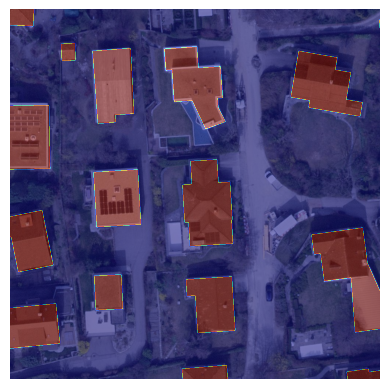

In [16]:
from plotting import plot_mask_on_image

sample = os.listdir(images_folder)[4]
sample_path = os.path.join(images_folder, sample)
plot_mask_on_image(sample_path, roof_masks[sample[:-4]], "")

Works well ! We thus want to save the masks under two formats.
- The first one is a binary mask, where the rooftops are white and the rest is black. We will save them in the `data/roofs/masks` folder.
- The other one modifies our images, only keeping the roofs and coloring the rest as magenta. We will save them in the `data/roofs/images` folder.

In [18]:
# Binary roof masks
for name, mask in tqdm(roof_masks.items(), desc="Saving masks"):
    output_path = os.path.join(roof_masks_folder, name + ".png")
    Image.fromarray((mask * 255).astype(np.uint8)).save(output_path)

# Colored images
for name, mask in tqdm(roof_masks.items(), desc="Keeping roofs"):
    image_path = os.path.join(images_folder, name + ".jpg")
    output_path = os.path.join(roof_images_folder, name + ".jpg")
    keep_roofs(image_path=image_path, output_path=output_path, mask=mask)

Keeping roofs: 100%|██████████| 500/500 [00:13<00:00, 37.93it/s]


## Create the labels

Our final step is creating the labels that will be used by our model. We labelled the data using an online [tool](https://encord.com) where we could draw polygons around the solar panels. We labelled $758$ images corresponding to the $500$ images we previously created thanks to the tiles we just downloaded, and the additional $258$ images we had generated completely at random at the beginning. The labels are saved in the `data/labels` folder, as `.json` files. We will use this information to create masks for each image, where only solar panels are white and the rest is black. We will save them in the `data/labels` folder.

In [24]:
labels_df = load_json_labels("../data/labels/labels.json")
labels_df.sample(3)

,data_title,polygon,value
423,swissimage-dop10_2023_2554.8-1148.4.jpg,"{'0': {'x': 0.999018649138961, 'y': 0.61813299...",unsure
565,swissimage-dop10_2021_2661.0-1238.2.jpg,None,None
1452,swissimage-dop10_2021_2585.3-1214.3.jpg,"{'0': {'x': 0.4505351580965665, 'y': 0.8164912...",solar_panel


The given data frame contains one or several rows for each image, each row corresponding to a different solar panel (`polygon` column is set to `None` if there are no solar panels on the image).

In [25]:
image_names = labels_df["data_title"].unique()
print(f'There are {labels_df.isna().sum()["polygon"]} images that have no solar panels, out of {len(image_names)} images.')
label_masks = generate_label_masks(labels_df)

There are 336 images that have no solar panels, out of 758 images.


Creating masks: 100%|██████████| 1842/1842 [00:01<00:00, 1094.31it/s]


Again, as a sanity check, let's plot one of the masks on top of its corresponding image.

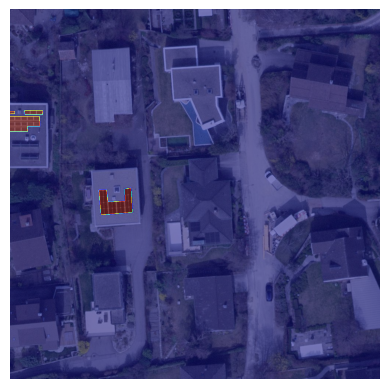

In [26]:
image_name = os.listdir(images_folder)[4]
image_path = os.path.join(images_folder, image_name)
label_mask = label_masks[image_name]
plot_mask_on_image(image_path, label_mask, "")

Let's also see if it matches our *rooftop-only* image.

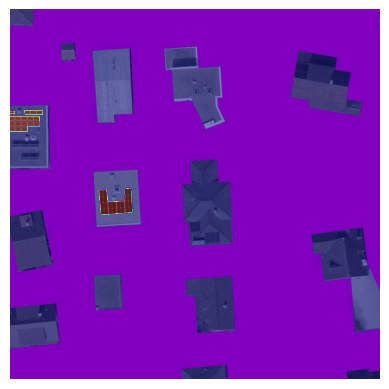

In [27]:
image_path = os.path.join(roof_images_folder, image_name[:-4] + ".jpg")
plot_mask_on_image(image_path, label_mask, "")

Works super well, let's save them.

In [28]:
labels_folder = "../data/labels"
for name, label_mask in tqdm(label_masks.items(), desc="Saving labels"):
    image = Image.fromarray(label_mask.reshape(1000, 1000).astype(np.uint8) * 255)
    image.save(os.path.join(labels_folder, name[:-4] + ".png"))

Saving labels: 100%|██████████| 758/758 [00:09<00:00, 79.85it/s]


We're done ! We have our original images, our images with only the rooftops and our corresponding labels. We can now use them to train our model, in another notebook.